### Genetic Algorithm Can Accurately Navigate Structure Space for Low Viscosity Ionic Liquids
1. X versions - no RDKit integration
2. X versions - RDKit integration
    1. atomic mutations, alpha-num fitness test, fixed bonds, non-random starting structure
    2. atomic mutations, similarity map fitness test, fixed bonds, non-random starting structure
    3. atomic mutations, similarity map fitness test, bond mutations, non-random starting structure
    4. atomic mutations, similarity map fitness test, bond mutations, random starting structure
3. X versions - viscosity fitness tests
4. X versions - performance upgrades using clustering/similarity maps
5. X versions - different search structures


In [2]:
import rdkit
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import rdFMCS
import random
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

# Replace atoms

In [2]:
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def mutate(parent, geneSet, get_fitness):
    childGenes = parent
    while True:
        oldGene, alternate = random.sample(range(0,childGenes.Mol.GetNumAtoms()), 2)
        if childGenes.Mol.GetAtomWithIdx(alternate).IsInRing() == False and\
                childGenes.Mol.GetAtomWithIdx(oldGene).IsInRing() == False:
            break
    newGene = random.sample(geneSet, 1)[0]
    try:
        childGenes.Mol.GetAtomWithIdx(alternate).SetAtomicNum(newGene) if\
              childGenes.Mol.GetAtomWithIdx(oldGene).GetFormalCharge() != 0 else\
              childGenes.Mol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene)
        Chem.SanitizeMol(childGenes.Mol)
        genes = Chem.MolToSmiles(childGenes.Mol)
        fitness = get_fitness(genes, target)
        return Chromosome(genes, fitness)
    except:
        genes = Chem.MolToSmiles(parent.Mol)
        return Chromosome(genes, 0)
        pass    

In [6]:
target = "CNCN[NH+]1C=CN(C1C)C"
geneSet = [5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "CCCC[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)
print(parent.Fitness)
while parent.Fitness < 0.6:
    child = mutate(parent, geneSet, get_fitness)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child

0.36524822695035464
child adopted!	BN1C=C[NH+](CCCF)C1C	0.3730407523510972
child adopted!	FPCC[NH+]1C=CN(P)C1S	0.375366568914956
child adopted!	BNNN[NH+]1C=CN(C)C1P	0.40390879478827363
child adopted!	BNNN[NH+]1C=CN(C)C1N	0.41496598639455784
child adopted!	BC1N(O)C=C[NH+]1NCON	0.41590214067278286
child adopted!	CCCC[NH+]1C=CN(N)C1P	0.4336569579288026
child adopted!	NN1C=C[NH+](CCCF)C1P	0.43450479233226835
child adopted!	NN1C=C[NH+](CCCP)C1P	0.43870967741935485
child adopted!	CC1N(N)C=C[NH+]1NNOF	0.4391891891891892
child adopted!	CONN[NH+]1C=CN(P)C1C	0.4668769716088328
child adopted!	CC1N(C)C=C[NH+]1NONP	0.5519713261648745
child adopted!	CC1N(C)C=C[NH+]1NONN	0.5543478260869565
child adopted!	CC1N(C)C=C[NH+]1NOCN	0.573943661971831
child adopted!	CC1N(C)C=C[NH+]1NBBN	0.6174242424242424
child adopted!	CC1N(N)C=C[NH+]1NCNN	0.6245059288537549
child adopted!	CC1N(C)C=C[NH+]1NCSP	0.7222222222222222


# Add atoms

GA is biased toward removing atoms with current similarity mapping. A good solution with be one that improves the overall functionality of the genetic engine.

try: 
1. bias until number of atoms match target
2. find MCS and start from there
3. combination of 1 and 2
4. **add segments to geneSet**


In [3]:
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.RWMol(Chem.MolFromSmiles(genes))
        self.EditableMol = Chem.EditableMol(Chem.MolFromSmiles(genes))
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def mutate(parent, geneSet, get_fitness):
    childGenes = parent
    mutate_operations = ["replace atom", "add atom", "remove atom"]
    mutation_type = random.sample(mutate_operations, 1)[0]
    if mutation_type == "replace atom":
        while True:
            oldGene, alternate = random.sample(range(0,childGenes.RWMol.GetNumAtoms()), 2)
            if childGenes.RWMol.GetAtomWithIdx(alternate).IsInRing() == False and\
                    childGenes.RWMol.GetAtomWithIdx(oldGene).IsInRing() == False:
                break
        newGene = random.sample(geneSet, 1)[0]
        try:
            childGenes.RWMol.GetAtomWithIdx(alternate).SetAtomicNum(newGene) if\
                  childGenes.RWMol.GetAtomWithIdx(oldGene).GetFormalCharge() != 0 else\
                  childGenes.RWMol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass    
    elif mutation_type == "remove atom":
        
        while True:
            oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
            if childGenes.RWMol.GetAtomWithIdx(oldGene).GetExplicitValence() == 1:
                break
        try:
            childGenes.RWMol.RemoveAtom(oldGene)
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass
    elif mutation_type == "add atom":
        oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
        newGeneNumber = childGenes.RWMol.GetNumAtoms()
        
        try:
            childGenes.RWMol.AddAtom(Chem.Atom(newGene))
            childGenes.RWMol.AddBond(newGeneNumber,oldGene,Chem.BondType.SINGLE) 
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass

a new parent!	CCCC[NH+]1C=CN(C1C)C	0.36524822695035464
child adopted!	CCCP[NH+]1C=CN(C)C1C	0.3738019169329074
child adopted!	BS[NH+]1C=CNC1	0.5084745762711864


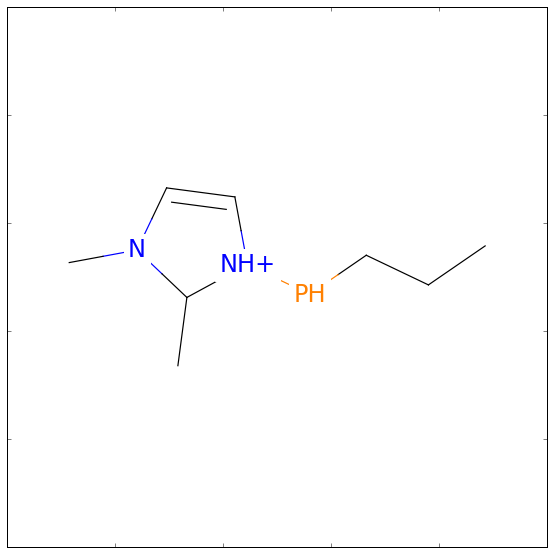

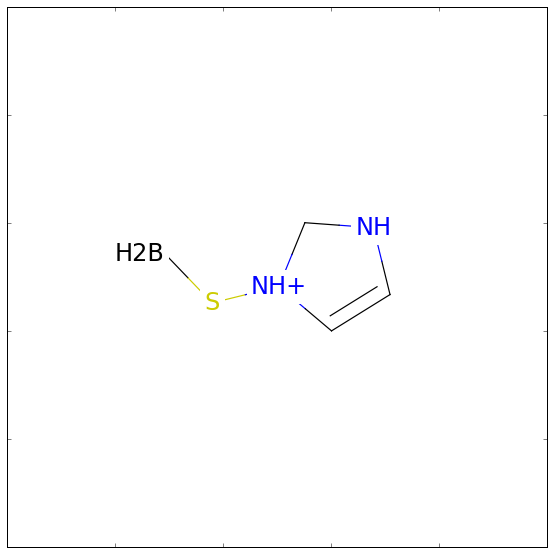

In [4]:
target = "CNCN[NH+]1C=CN(C1C)C"
geneSet = [5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "CCCC[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)
print("{}\t{}\t{}".format("a new parent!",parent.Genes,parent.Fitness))
while parent.Fitness < 0.5:
    child = mutate(parent, geneSet, get_fitness)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child
        mw = Chem.MolFromSmiles(parent.Genes)
        ax = Draw.MolToMPL(mw)

# Add fragments

In [2]:
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.RWMol(Chem.MolFromSmiles(genes))
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def mutate(parent, geneSet, get_fitness):
    childGenes = Chromosome(parent.Genes,0)
    mutate_operations = ["add fragment", "remove atom", "replace atom", "add atom"]
    mutation_type = random.sample(mutate_operations, 1)[0]
    if mutation_type == "replace atom":
        oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
        if childGenes.RWMol.GetAtomWithIdx(oldGene).IsInRing() == True:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        newGene = random.sample(geneSet, 1)[0]
        try:
            childGenes.RWMol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene) 
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass    
    elif mutation_type == "add atom":
        oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
        newGeneNumber = childGenes.RWMol.GetNumAtoms()   
        try:
            newGene = random.sample(geneSet, 1)[0]
            childGenes.RWMol.AddAtom(Chem.Atom(newGene))
            childGenes.RWMol.AddBond(newGeneNumber,oldGene,Chem.BondType.SINGLE) 
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)

        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass
    elif mutation_type == "add fragment":
        try:
            RDKitOrCustom = random.sample([0,1],1)[0]
            if RDKitOrCustom == 1:
                newGene = Chromosome(Chem.MolToSmiles(fparams.GetFuncGroup(\
                    random.sample(range(fparams.GetNumFuncGroups()), 1)[0])),0)
            else:
                newGene = Chromosome(fcat.GetEntryDescription(\
                    random.sample(range(fcat.GetNumEntries()), 1)[0]),0)
            combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,childGenes.Mol))
            oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]\
                + newGene.Mol.GetNumAtoms()
            if RDKitOrCustom == 1:
                combined.AddBond(1,oldGene,order=Chem.rdchem.BondType.SINGLE)
                combined.RemoveAtom(0)
            else:
                combined.AddBond(0,oldGene,order=Chem.rdchem.BondType.SINGLE)
            childGenes = combined.GetMol()
            Chem.SanitizeMol(childGenes)
            genes = Chem.MolToSmiles(childGenes)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:    
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass
    elif mutation_type == "remove atom":
        oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
        if childGenes.RWMol.GetAtomWithIdx(oldGene).GetExplicitValence() != 1:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        try:
            childGenes.RWMol.RemoveAtom(oldGene)
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass

a new parent!	[NH+]1C=CN(C1C)C	0.580952380952381
child adopted!	CCCC1=C[NH+]C(C)N1C	0.5899581589958159
child adopted!	CCCC1=C[NH+]C(C)N1CC	0.604
child adopted!	CCCC1=C[NH+](C)C(C)N1CC	0.6463878326996197
child adopted!	CCCC1=C[NH+](C)C(C)N1CCC	0.6541353383458647
child adopted!	CCCCN1C(CCC)=C[NH+](C)C1C	0.6616541353383458
child adopted!	CCCCN1C(CC)=C[NH+](C)C1C	0.6848249027237354
child adopted!	CCCCN1C(C)=C[NH+](C)C1C	0.7619047619047619
child adopted!	CCCCN1C=C[NH+](C)C1C	1.0


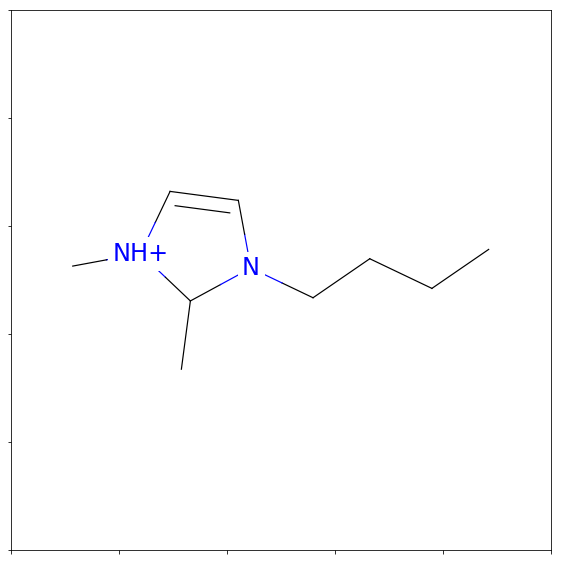

In [3]:
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,5,fName)
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
m1 = Chem.MolFromSmiles('CCCC')
fcgen.AddFragsFromMol(m1,fcat)

target = "CCCC[NH+]1C=CN(C1C)C"
geneSet = [6,7]#[5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)

print("{}\t{}\t{}".format("a new parent!",parent.Genes,parent.Fitness))

while parent.Fitness < 0.9:
    child = mutate(parent, geneSet, get_fitness)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child
mw = Chem.MolFromSmiles(parent.Genes)
ax = Draw.MolToMPL(mw)

# Make it Pythonic

In [121]:
class GeneSet():
    def __init__(self, atoms, rdkitFrags, customFrags):
        self.Atoms = atoms
        self.RdkitFrags = rdkitFrags
        self.CustomFrags = customFrags
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.RWMol(Chem.MolFromSmiles(genes))
def _generate_geneset():
    atoms = [6,7]
    fName = os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
    rdkitFrags = FragmentCatalog.FragCatParams(1,5,fName)
    customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
    fcgen = FragmentCatalog.FragCatGenerator()
    m = Chem.MolFromSmiles('CCCC')
    fcgen.AddFragsFromMol(m,customFrags)
    return GeneSet(atoms, customFrags, rdkitFrags)
def _get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def _mutate(parent, geneSet, get_fitness, target):
    def replace_atom(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.Atoms
        if childGenes.RWMol.GetAtomWithIdx(oldGene).IsInRing() == True:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        newGene = random.sample(geneSet, 1)[0]
        childGenes.RWMol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene) 
        return childGenes  
    def add_atom(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.Atoms
        newGeneNumber = childGenes.RWMol.GetNumAtoms()  
        newGene = random.sample(geneSet, 1)[0]
        childGenes.RWMol.AddAtom(Chem.Atom(newGene))
        childGenes.RWMol.AddBond(newGeneNumber,oldGene,Chem.BondType.SINGLE) 
        return childGenes
    def remove_atom(childGenes, GeneSet, oldGene):
        if childGenes.RWMol.GetAtomWithIdx(oldGene).GetExplicitValence() != 1:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        childGenes.RWMol.RemoveAtom(oldGene)
        return childGenes
    def add_custom_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.CustomFrags
        try:
            newGene = Chromosome(Chem.MolToSmiles(geneSet.GetFuncGroup(\
            random.sample(range(geneSet.GetNumFuncGroups()), 1)[0])),0)
        except:
            return 0
        oldGene = oldGene + newGene.Mol.GetNumAtoms()
        combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,childGenes.Mol))
        combined.AddBond(1,oldGene,order=Chem.rdchem.BondType.SINGLE)
        combined.RemoveAtom(0)
        try:
            childGenes = Chromosome(Chem.MolToSmiles(childGenes),0)  
            return childGenes
        except:
            return 0
    def add_rdkit_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.RdkitFrags
        newGene = Chromosome(geneSet.GetEntryDescription(\
        random.sample(range(geneSet.GetNumEntries()), 1)[0]),0)
        oldGene = oldGene + newGene.Mol.GetNumAtoms()
        combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,childGenes.Mol))
        combined.AddBond(0,oldGene,order=Chem.rdchem.BondType.SINGLE)
        childGenes = combined.GetMol()   
        try:
            childGenes = Chromosome(Chem.MolToSmiles(childGenes),0)  
            return childGenes
        except:
            return 0
    childGenes = Chromosome(parent.Genes,0)
    oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
    mutate_operations = [add_rdkit_fragment, add_custom_fragment, remove_atom, replace_atom, add_atom]
    i = random.choice(range(len(mutate_operations)))
    childGenes = mutate_operations[i](childGenes, geneSet, oldGene)
    try:
        childGenes.RWMol.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(childGenes.RWMol)
        genes = Chem.MolToSmiles(childGenes.RWMol)
        fitness = get_fitness(genes, target)
        return Chromosome(genes, fitness)
    except:
        return Chromosome(parent.Genes, 0)

a new parent!	[NH+]1C=CN(C1C)C	0.580952380952381
child adopted!	CCC1(C)[NH+]C=CN1C	0.6023391812865497
child adopted!	CC[NH+]1C=CN(C)C1(C)CC	0.648068669527897
child adopted!	CCCN1C=C[NH+](CC)C1(C)CC	0.6790123456790124
child adopted!	CCCCCN1C=C[NH+](CC)C1(C)CC	0.701195219123506
child adopted!	CCCCN1C=C[NH+](CC)C1(C)CC	0.7154471544715447
child adopted!	CCCCN1C=C[NH+](CC)C1CC	0.8712871287128713
child adopted!	CCCCN1C=C[NH+](C)C1CC	0.8979591836734694
child adopted!	CCCCN1C=C[NH+](C)C1C	1.0


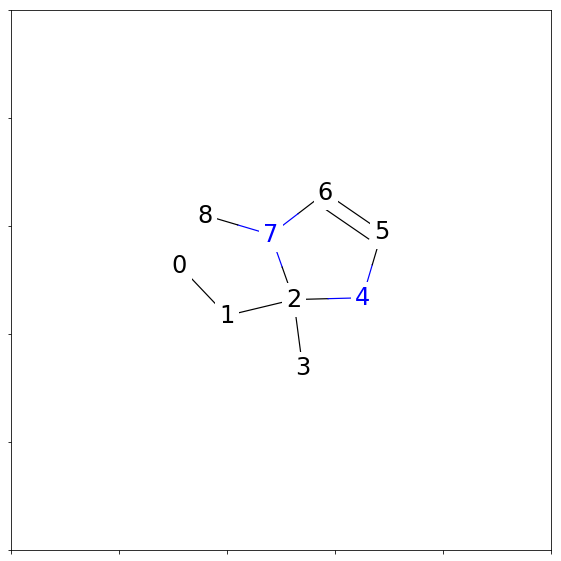

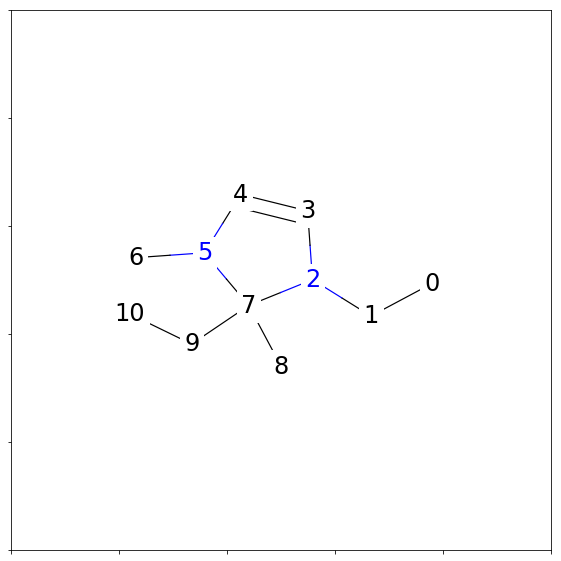

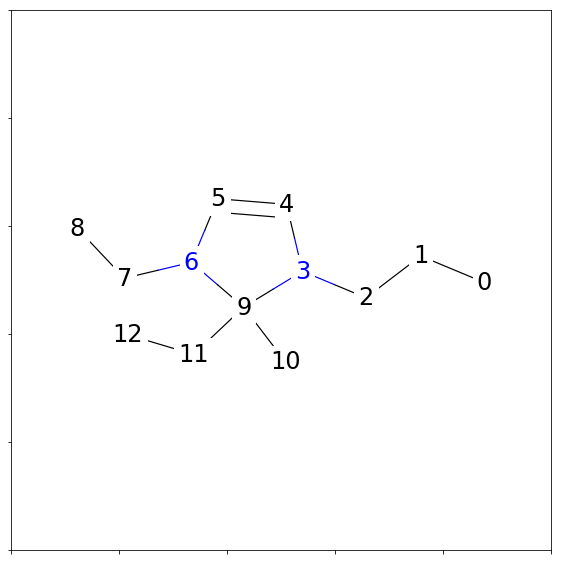

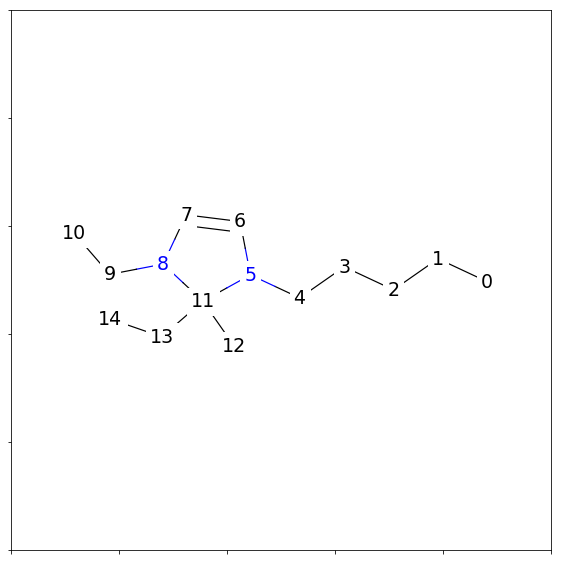

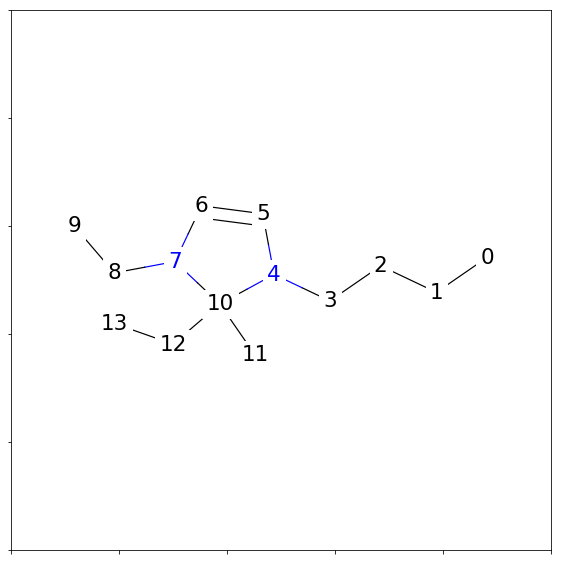

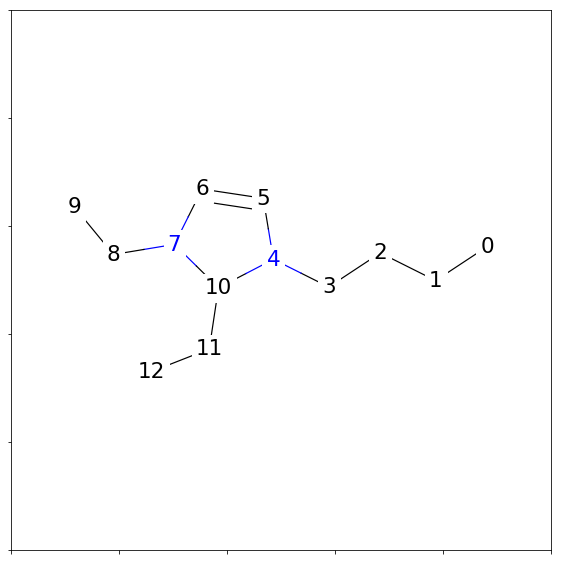

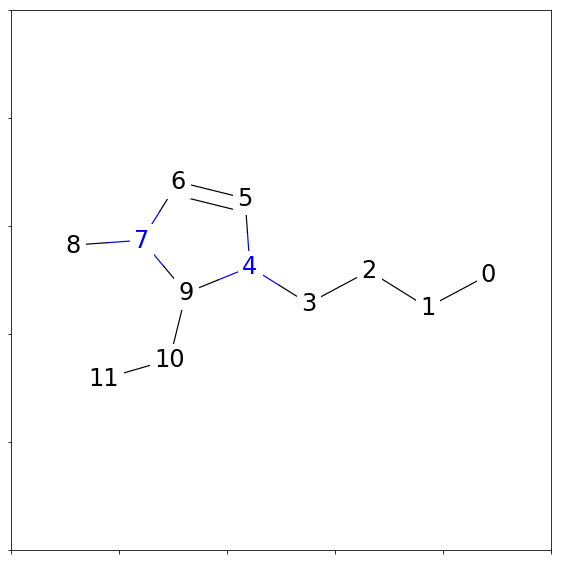

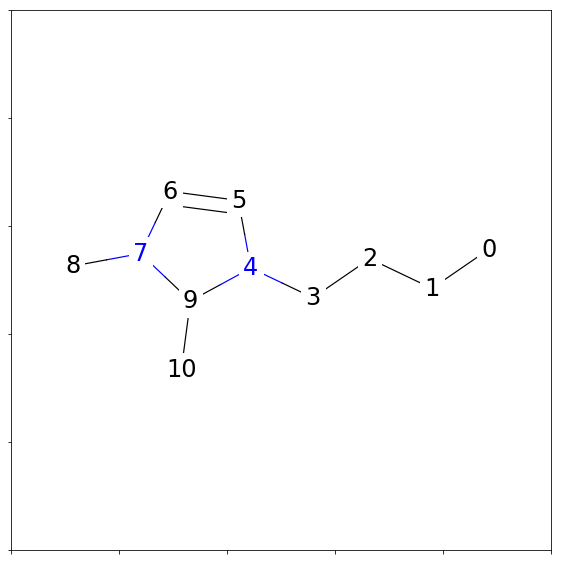

In [122]:
geneSet = _generate_geneset()

target = "CCCC[NH+]1C=CN(C1C)C"
# geneSet = [6,7]#[5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "[NH+]1C=CN(C1C)C"
fitness = _get_fitness(genes, target)
parent = Chromosome(genes,fitness)

print("{}\t{}\t{}".format("a new parent!",parent.Genes,parent.Fitness))

while parent.Fitness < 1:
    child = _mutate(parent, geneSet, _get_fitness, target)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child
        mw = Chem.MolFromSmiles(parent.Genes)
        ax = Draw.MolToMPL(mw)

0
1
3


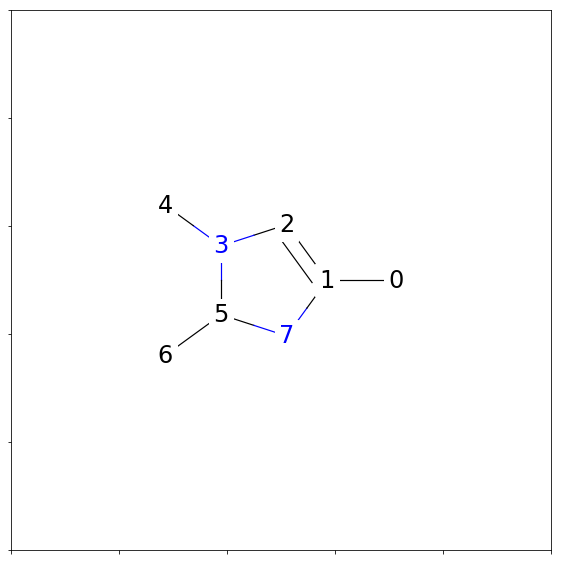

In [118]:
from rdkit.Chem.Draw import DrawingOptions
target="CC1=CN(C)C(C)[NH+]1"
DrawingOptions.includeAtomNumbers=True
mol=Chem.MolFromSmiles(target)
atom = mol.GetAtomWithIdx(7)
img = Draw.MolToMPL(mol)
# print(Chem.GetPeriodicTable().GetNOuterElecs(atom.GetAtomicNum()))
# print(atom.GetExplicitValence()-atom.GetNumExplicitHs())
# print(atom.GetImplicitValence())
# print(atom.GetTotalValence())
# print(atom.GetDegree())
print(atom.GetNumImplicitHs())
print(atom.GetNumExplicitHs())
print(atom.GetExplicitValence())

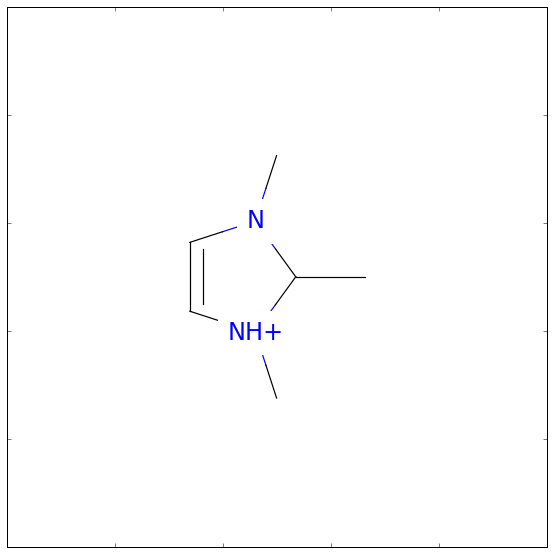

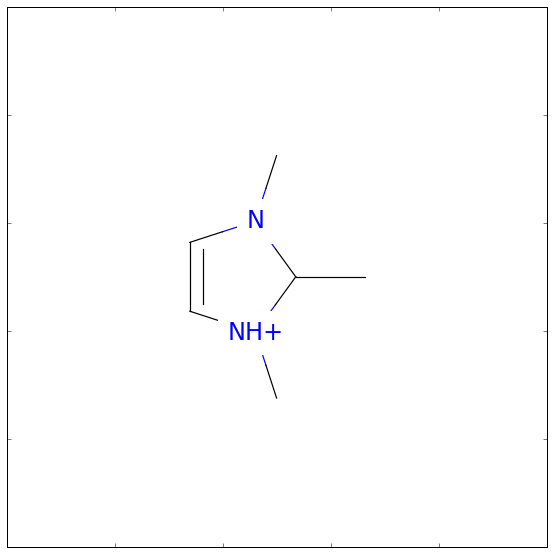

In [45]:
genes="CC1N(C)C=C[NH+]1C"
Draw.MolToMPL(m)

number of atoms: 	8
atom C ring status:	False
atom C ring status:	False
atom N ring status:	False
atom C ring status:	False
atom C ring status:	False
atom N ring status:	False
atom C ring status:	False
atom C ring status:	False


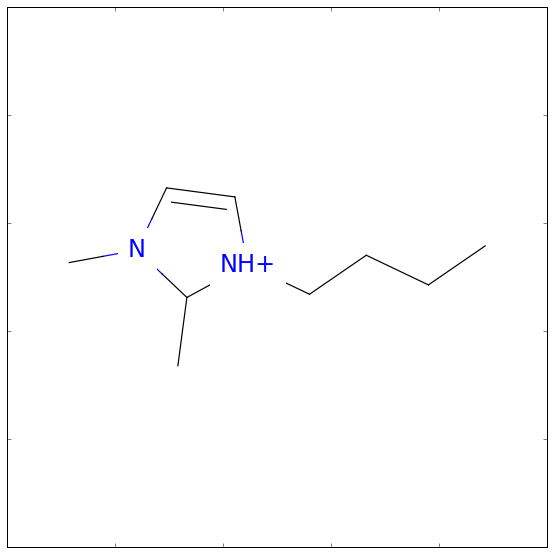

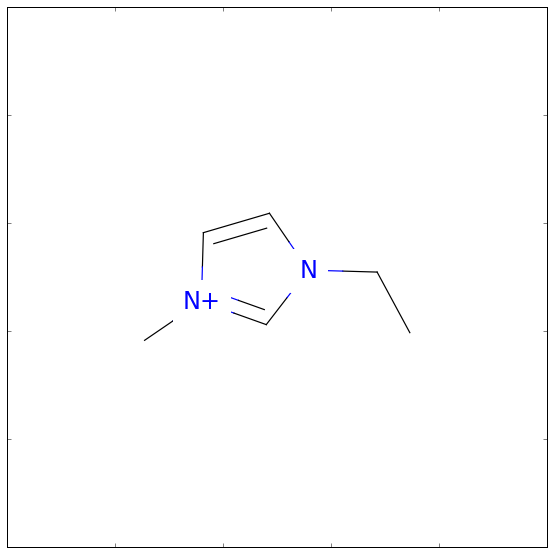

In [58]:
df = pd.read_csv("saltInfo.csv")
mol1 = Chem.MolFromSmiles(df["cation_SMILES"][0])
mol2 = Chem.MolFromSmiles(df["cation_SMILES"][1])
mols = [mol1,mol2]
res=rdFMCS.FindMCS(mols)
mol = Chem.MolFromSmarts(res.smartsString)
print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
for atom in mol.GetAtoms():
    print("{}\t{}".format("atom %s ring status:"\
            %atom.GetSymbol(), atom.IsInRing()))
ax1=Draw.MolToMPL(mol1)
ax2=Draw.MolToMPL(mol2)

a new parent!	[NH+]1C=CN(C1C)C	0.580952380952381
4
7


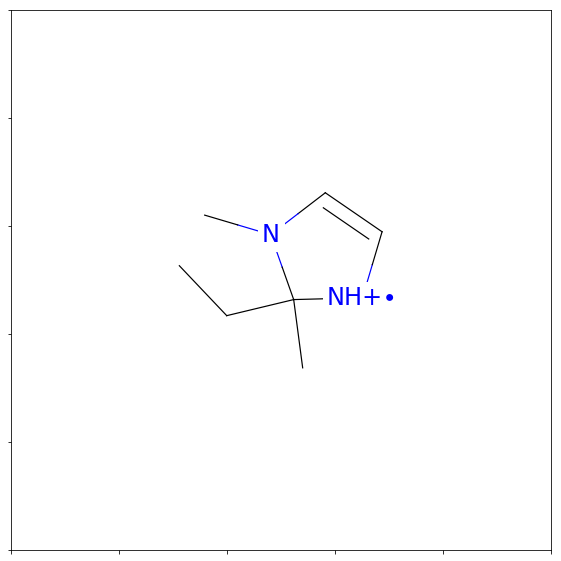

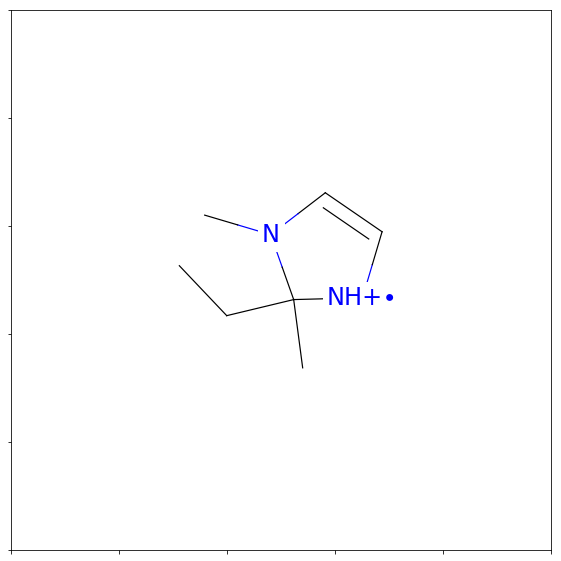

In [133]:
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,5,fName)
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
m1 = Chem.MolFromSmiles('CCCC')
fcgen.AddFragsFromMol(m1,fcat)

target = "CCCC[NH+]1C=CN(C1C)C"
geneSet = [6,7]#[5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)

print("{}\t{}\t{}".format("a new parent!",parent.Genes,parent.Fitness))

childGenes = Chromosome(parent.Genes,0)


newGene = Chromosome(fcat.GetEntryDescription(\
    random.sample(range(fcat.GetNumEntries()), 1)[0]),0)

combined = Chem.EditableMol(Chem.CombineMols(childGenes.Mol,newGene.Mol))

oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
print(oldGene)
print(childGenes.Mol.GetNumAtoms())
combined.AddBond(oldGene,childGenes.Mol.GetNumAtoms(),order=Chem.rdchem.BondType.SINGLE)
childGenes = combined.GetMol()
Chem.SanitizeMol(childGenes)
genes = Chem.MolToSmiles(childGenes)
fitness = get_fitness(genes, target)
m = Chromosome(genes,fitness)
Draw.MolToMPL(m.Mol)